# 加载

In [1]:
import plotly.graph_objects as go
import datetime
from datetime import datetime
import random
import calendar
import time
import seaborn as sns
import tensorflow as tf
from sklearn import svm
from subprocess import call
from scipy import signal
from sklearn import tree
from sklearn import neighbors
import sklearn
from matplotlib.lines import Line2D
import statsmodels.tsa.stattools as ts
import matplotlib.ticker as mtick
import matplotlib.collections as collections
from numpy import linalg
from IPython.display import Image
import os
import graphviz
import sys
import csv
import pandas as pd 
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
from arch import arch_model
import numpy as np
import warnings
import xgboost as xgb
from sklearn.tree import export_graphviz
from sklearn import datasets
warnings.filterwarnings("ignore")
import math
import operator
import statsmodels.api as sm
import statsmodels.tsa.stattools as ts
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.font_manager as fm
from sklearn import preprocessing
from sklearn import linear_model
from statsmodels.tsa.arima_model import ARIMA
from sklearn.decomposition import PCA
from scipy.stats import pearsonr
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from scipy import stats
from copy import deepcopy
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression
from datetime import datetime
from sklearn.tree import DecisionTreeRegressor 
from sklearn.ensemble import RandomForestRegressor 
from sklearn.feature_extraction import DictVectorizer
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.model_selection import cross_validate
from WindPy import w
from numpy import exp, array, random, dot
w.start()

Welcome to use Wind Quant API for Python (WindPy)!

COPYRIGHT (C) 2020 WIND INFORMATION CO., LTD. ALL RIGHTS RESERVED.
IN NO CIRCUMSTANCE SHALL WIND BE RESPONSIBLE FOR ANY DAMAGES OR LOSSES CAUSED BY USING WIND QUANT API FOR Python.


.ErrorCode=0
.Data=[OK!]

# 函数

## 神经网络

In [2]:
#激活函数及坡度
def sig(x):
    return 1 / (1 + exp(-x))

def sig_drv(x):
    return x * (1-x)

#生成初始神经网络
def gen_layer(x,y,nnum):
    res = [2 * random.random((len(x[0]), nnum[0])) - 1]
    if len(nnum) > 1:
        for i in range(1,len(nnum)):
            res.append(2 * random.random((nnum[i-1], nnum[i])) - 1)
    res.append(2 * random.random((nnum[-1], len(y[0]))) - 1)
    return res

#输入结果
def calc(x, nn):
    res = []
    for i in range(len(nn)):
        if i == 0:
            res.append(sig(dot(x, nn[i])))
        else:
            res.append(sig(dot(res[-1], nn[i])))
    return res

#训练
def correct(x, y, nnum, time,prt):
    layer = gen_layer(x,y,nnum)
    for j in range(time):
        res = calc(x, layer)
        det = []
        err = []
        adj = []
        for i in range(len(layer)-1,-1,-1):
            if i == len(layer)-1:
                err.append(y - res[-1])
                det.append(err[0] * sig_drv(res[-1]))
            else:
                err.append(det[-1].dot((layer[i+1]).T))
                det.append(err[-1] * sig_drv(res[i]))
        
        det = det[::-1]
        for i in range(len(det)):
            if i == 0:
                adj.append((x.T).dot(det[i]))
            else:
                adj.append((res[i-1].T).dot(det[i]))        
        for i in range(len(layer)):
            layer[i] += adj[i]
    if prt:
        print('神经层',layer)
    return layer

## @@@@@@@@@@@多组数据加工

In [3]:
def maxmin(data,i):
    c = 1
    direction = data[i] >= data[i-1]

In [4]:
#l选取数据时长
def data_pro(data,l):
    df = []
    for i in range(l-1,len(date)):
        temp = []
        for j in range(len(data)):
            i = int(i)
            j = int(j)
            
            #选取第j组数据
            il = data[j][i-l+1:i+1]
            
            temp.append(-(-1) ** (data[j][i] >= np.mean(il)))
            temp.append(-(-1) ** (data[j][i] >= np.mean(il[3:])))
            temp.append(-(-1) ** (data[j][i] >= np.mean(il[6:])))
            temp.append(-(-1) ** (data[j][i] >= np.mean(il[9:])))
            temp.append(-(-1) ** (data[j][i] >= data[j][i-1]))
            
            #ROC 
            temp.append(il[-1]/(il[-2]+10e-4)-1)
            temp.append(il[-1]/(il[-4]+10e-4)-1)
            temp.append(il[-1]/(il[-7]+10e-4)-1)
            temp.append(il[-1]/(il[-10]+10e-4)-1)
            temp.append(il[-1]/(il[0]+10e-4)-1)
            
        df.append(temp)
    return df

## 预测结果评估

In [5]:
#准确度计算
def acc(res,ans):
    if len(res) != len(ans):
        return('准确度数据长度不同')
    else:
        return round(sum(np.array(res) == np.array(ans))/ len(res),2)

#收益率计算
def profit(data, ud):
    if len(data) != len(ud):
        return('收益率数据长度不同')
    money = 1
    num = 0
    prt = 0   #显示买卖记录
    m2y = 1   #是否年化收益
    for i in range(len(data)):
        if ud[i] == 1 and num == 0:
            if prt:
                print('in', date[11:][i], 'money', money, 'num', num, 'price', data[i])
 
            num = money/(data[i]+10e-6)
            money = 0
        if ud[i] == -1 and money == 0 and data[i] != 0:
            if prt:
                print('out', date[11:][i], 'money', money, 'num', num, 'price', data[i])
            money = num * data[i]
            num = 0
    if prt:
        print('结果',money+num*data[-1])
    if m2y:
        return (money+num*data[-1]) ** (1/len(data))-1
    return money+num*data[-1]-1

#错误区间占比
def wrong_div(dat, ud):
    if len(dat) != len(ud):
        return('错误区间数据长度不同')
    
    c_div = 1
    c_wrong = 0
    l_wrong = 1
    l_all = 0
    dirc = ud[0]
    last = dat[0]
    for i in range(1,len(dat)):
        l_wrong += 1
        if ud[i] == 0:
            return str(c_wrong)+'/'+str(c_div), str(l_all)+'/'+str(len(dat))
        if ud[i] != dirc:
            c_div += 1
            if -(-1)**(dat[i] > last) != dirc:
                c_wrong += 1
                l_all += l_wrong
            l_wrong = 1
            last = dat[i]
            dirc = ud[i]
            
    return str(c_wrong)+'/'+str(c_div), str(l_all)+'/'+str(len(data))

#复杂度计算
def cpx(x):
    res = 1
    dirc = x[0]
    for i in range(len(x)):
        if x[i] != dirc:
            res += 1
            dirc = x[i]
    return res/len(x)

## 趋势划分

In [6]:
def und(dat, l1, l2):
    i = 0
    res = [0] * len(dat)

    while i < len(dat)-1:
        if i + l2 >= len(dat):
            break
        cur = dat[i]
        next_id = min([(dat[i+1:]).index(max(dat[i+1+l1:i+1+l2])), (dat[i+1:]).index(min(dat[i+1+l1:i+1+l2]))]) +i+1
        res[i:next_id+1] = [- (-1) ** (dat[next_id] > dat[i])] * (next_id + 1 - i)
        i = next_id
    return res

In [7]:
def und_pro(dat, l1, l2):
    i = 0
    see = []
    res = [0] * len(dat)

    while i < len(dat)-1:
        if i + l1 >= len(dat) - 1 - l2:
            for j in range(i, len(dat)-l2):
                res[j] = res[i]
            break
        cur = dat[i]
        next_id = min([(dat[i+1:]).index(max(dat[i+1+l1:i+1+l2])), (dat[i+1:]).index(min(dat[i+1+l1:i+1+l2]))]) +i+1
        res[i:next_id+1] = [- (-1) ** (dat[next_id] > dat[i])] * (next_id + 1 - i)
        i = next_id
        temp = deepcopy(res)
        see.append(temp)
    return see

## 滞后调整

In [8]:
def lag(data,i,step):
    res = []
    for j in range(step,len(data)):
        temp = []
        for k in range(len(data[0])):
            if k != i:
                temp.append(data[j][k])
            else:
                temp.append(data[j][k-step])
        res.append(temp)
    return res

In [9]:
def lagrid(data, lag):
    res = []
    m_lag = max(lag)
    for i in range(len(data)):
        if lag[i] == m_lag:
            res.append(data[i][lag[i]:])
        else:
            res.append(data[i][lag[i]:-(m_lag-lag[i])])
    return res

## 转置list

In [10]:
def listran(data):
    x = []
    for i in range(len(data[0])):
        temp = []
        for j in range(len(data)):
            temp.append(data[j][i])
        x.append(temp)
    return x

## 移动平均，大小比较与时间处理

### 滤波生成

In [11]:
def hp(data):
    cycle, trend = sm.tsa.filters.hpfilter(data, lamb=129600)
    return trend

### 拐点识别

In [12]:
def tar(ud):
    res = [0]
    cur = ud[0]
    for i in range(1,len(ud)):
        if ud[i] != cur and ud[i] != 0:
            res.append(ud[i])
            cur = ud[i]
        else:
            res.append(0)
    return res

### 去春节性

In [13]:
#通过平均去春节影响
def spring(data, date):
    res = []
    for i in range(len(data)):
        if i == 0 and date[i].month == 2:
            res.append(data[i])
        if date[i].month == 1 and i < len(date)-1:
            temp = deepcopy(data[i]+data[i+1])/2
            res.append(temp)
            res.append(temp)
        elif date[i].month == 2:
            continue
        else:
            res.append(data[i])
    return res

### 波峰波谷

In [14]:
#波峰挑选
def peak(data):
    res = [0]
    for i in range(1, len(data)-1):
        if data[i-1] < data[i] > data[i+1]:
            res.append(data[i])
        else:
            res.append(0)
    res.append(0)
    return res

#波谷挑选
def bot(data):
    res = [0]
    for i in range(1, len(data)-1):
        if data[i-1] > data[i] < data[i+1]:
            res.append(data[i])
        else:
            res.append(0)
    res.append(0)
    return res

### 清理重复月份，需要月数据！！！

In [15]:
#清理重复的月份
def date_clean(date,data):
    date_res = [date[0]]
    data_res = [[i[0]] for i in data]
    
    last = date[0]
    
    for i in range(len(date[1:])):
        cur = date[i]
        if cur.month != last.month:
            date_res.append(cur)
            for j in range(len(data_res)):
                data_res[j].append(data[j][i])
        last = date[i]

    return date_res, data_res

### 移动平均相关

In [16]:
#data l_ma长度的移动平均线
def ma(data, l_ma):
    res = []
    for i in range(l_ma-1,len(data)):
        res.append(np.mean(data[i-l_ma+1:i+1]))
    return res

#ROCSMA变化率移动平均
def rocsma(d1,i1,l_roc,l_sma):
    res = 0
    for x in range(l_sma):
        res += (d1[i1-x]/d1[i1-x-l_roc]-1)/l_sma
    return res

#KST公式
def kst(d2,roc_l1,roc_l2,roc_l3,roc_l4,sma_l1,sma_l2,sma_l3,sma_l4):
    res = []
    for i in range(roc_l4+sma_l4, len(d2)):
        rocma1 = rocsma(d2,i,roc_l1,sma_l1)
        rocma2 = rocsma(d2,i,roc_l2,sma_l2)
        rocma3 = rocsma(d2,i,roc_l3,sma_l3)
        rocma4 = rocsma(d2,i,roc_l4,sma_l4)
        res.append(rocma1 * 1 + rocma2 * 2 + rocma3 * 3 + rocma4 * 4)
    return res

#加权移动平均
def ewma(data,l):
    aw = sum([i for i in range(1,13)])
    res = []
    for i in range(l-1, len(data)):
        temp = 0
        for j in range(l):
            temp += data[i-j]*(12-j)/aw
        res.append(temp)
    return res

### 序列大小判断

In [17]:
def slope(data):
    res = [0]
    for i in range(1,len(data)):
        res.append(-(-1) ** (data[i]>data[i-1]))
    res[0] = res[1]
    return res

### 获取下个月末的日期

In [18]:
#获取下个月末
def next_month(date):
    if date.month == 12:
        res = date.replace(year = date.year + 1, month = 1, day = calendar.monthrange(int(date.year+1), 1)[1])
    else:
        res = date.replace(month = date.month + 1, day = calendar.monthrange(int(date.year), date.month + 1)[1])
    return res

### 相对强度

In [19]:
#相对强度
def rele_str(data, i1, i2):
    return (np.array(data[i1])/np.mean(data[i1])) / (np.array(data[i2])/np.mean(data[i2]))

### 日期变为天数

In [20]:
def date2num(date):
    d8 = []
    for i in range(len(date)):
        d8.append(int((date[i] - date[0]).days))
    return d8

### 找年份

In [21]:
def find1y(date):
    last = date[0]
    for i in range(len(date)):
        cur = date[i]
        if cur.year != last.year:
            return i
        last = date[i]

### 其他

In [22]:
#检查长度
def clen(d1,d2):
    print(len(d1),len(d2))

#大小对比
def comp(d1,d2):
    if len(d1) != len(d2):
        return '长度不同'
    res = [-(-1) ** (d1[i] > d2[i]) for i in range(len(d1))]
    return res

#平均值规范化
def std(data):
    res = [1]
    for i in range(1, len(data)):
        res.append((data[i] - np.mean(data[:i]))/np.mean(data[:i]))
    return res

#相关性
def calc_corr(a, b):
    a_avg = sum(a)/len(a)
    b_avg = sum(b)/len(b)
 
    cov_ab = sum([(x - a_avg)*(y - b_avg) for x,y in zip(a, b)])
 
    sq = math.sqrt(sum([(x - a_avg)**2 for x in a])*sum([(x - b_avg)**2 for x in b]))

    corr_factor = cov_ab/sq
 
    return corr_factor


#???????????????????????
#交叉变换趋势
def cross(d1,d2,cd):
    comp = [-(-1) ** (d1[i] > d2[i]) for i in range(len(d1))]
    res = [-comp[0]]
    c = 0
    
    for i in range(1,len(comp)):
        if comp[i] * comp[i-1] == -1 and c == 0:
            sl1 = -(-1)**(d1[i]>d1[i-1])
            sl2 = -(-1)**(d2[i]>d2[i-1])
            res.append(sl1*sl2)
            c += cd
        else:
            res.append(res[-1])
            c = max(0,c-1)
    return res

#平滑折线
def smooth(data):
    for i in range(len(data)-4):
        if data[i] * data[i+2] == 1 and data[i] * data[i+1] == -1:
            data[i+1] = data[i]
        elif data[i] * data[i+3] == 1 and all(data[i+1:i+3]) != data[i]:
            for j in range(2):
                data[i+j+1] = data[i]
        elif data[i] * data[i+4] == 1 and all(data[i+1:i+4]) != data[i]:
            for j in range(3):
                data[i+j+1] = data[i]
    return data

def smooth2(data):
    for i in range(len(data)-5):
        if data[i] * data[i+5] == 1 and all(data[i+1:i+4]) != data[i]:
            for j in range(4):
                data[i+j+1] = data[i]
    return data

def l2n0(data):
    res = []
    for i in range(len(data)):
        if data[::-1][i] != 0:
            res.append(data[::-1][i])
        if len(res) == 2:
            break
    return res[0]/res[1]-1

## 训练验证集划分

In [23]:
#训练与验证集
def trvd(x, y, ratio):
    train_x = x[:int(len(x)*ratio)]
    valid_x = x[int(len(x)*ratio):]
    train_y = y[:int(len(x)*ratio)]
    valid_y = y[int(len(x)*ratio):]
    
    print(len(train_x), len(valid_x), len(train_y), len(valid_y))
    return train_x, valid_x, train_y, valid_y

## 画图

In [24]:
def supa_plot(d,ud,ii,m_name):
    plt.rcParams['font.family']=['SimHei']
    plt.rcParams['axes.unicode_minus']=False
    fig, ax = plt.subplots(figsize=(12,6))
    ax.set_title(list(d)[ii]+m_name+'预测',fontproperties='SimHei', size = 20)
    ax.plot(d8, data[ii], color='black', linewidth = 1, label = list(d)[ii])
    
    ll = len(data) - len(ud)
    
    plt.xlabel(u'年份',fontproperties='SimHei',fontsize = 20)
    plt.xticks([i for i in range(d8[find1y(date)],d8[-1],365)], [date[i].year for i in range(find1y(date),len(d8),12)])
    plt.ylabel(u'指数',fontproperties='SimHei',fontsize = 20)

    collection = collections.BrokenBarHCollection.span_where(
    d8[ll:], ymin=min(data[ii]), ymax=max(data[ii]), where=np.array(ud) == 1, facecolor='red', alpha=.15, label = '上行')
    ax.add_collection(collection)

    collection = collections.BrokenBarHCollection.span_where(
    d8[ll:], ymin=min(data[ii]), ymax=max(data[ii]), where=np.array(ud) == -1, facecolor='green', alpha=.15, label = '下行')
    ax.add_collection(collection)

    colors = ['black', 'red', 'green']
    new_legends = ["-"] * len(colors)
    markers = ['-'] * len(colors)
    
    _, labels = ax.get_legend_handles_labels()
    
    duplicates = [dupe_legend(leg, color) for leg, color in zip(new_legends, colors)]
    ax.legend(duplicates, labels, numpoints=1, markerscale=5, fontsize=13)
    
    plt.show()

def dupe_legend(label, color):
    line = Line2D([0], [0], linestyle='none', mfc= 'white',
                mec=color, marker=r'$\mathregular{{{}}}$'.format(label))
    return line

## 时间序列相关

In [25]:
#时间序列模型预测
def ts_predict(data, date, n_steps):
    
    f, err95, ci95 = best_mdl.forecast(steps=n_steps)
    idx = [date[-1]]
    for i in range(n_steps-1):
        idx.append(next_month(idx[-1]))
    fc_all = pd.DataFrame(np.column_stack([f, ci95]), index=idx, columns=['forecast', 'lower_ci_95', 'upper_ci_95'])
    return fc_all['forecast'][1]

def draw_trend(timeSeries, size):
    f = plt.figure(facecolor='white')
    # 对size个数据进行移动平均
    rol_mean = timeSeries.rolling(window=size).mean()
    # 对size个数据进行加权移动平均
    rol_weighted_mean = pd.ewma(timeSeries, span=size)

    timeSeries.plot(color='blue', label='Original')
    rolmean.plot(color='red', label='Rolling Mean')
    rol_weighted_mean.plot(color='black', label='Weighted Rolling Mean')
    plt.legend(loc='best')
    plt.title('Rolling Mean')
    plt.show()

def draw_ts(timeSeries):
    f = plt.figure(facecolor='white')
    timeSeries.plot(color='blue')
    plt.show()

def testStationarity(ts):
    dftest = adfuller(ts)
    # 对上述函数求得的值进行语义描述
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    return dfoutput

# 自相关和偏相关图，默认阶数为31阶
def draw_acf_pacf(ts, lags=31):
    f = plt.figure(facecolor='white')
    ax1 = f.add_subplot(211)
    plot_acf(ts, lags=31, ax=ax1)
    ax2 = f.add_subplot(212)
    plot_pacf(ts, lags=31, ax=ax2)
    plt.show()
    
def tsplot(y, lags=None, figsize=(10,8), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):#定义局部样式
        fig = plt.figure(figsize=figsize)
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1,0))
        pacf_ax = plt.subplot2grid(layout, (1,1))
        qq_ax = plt.subplot2grid(layout, (2,0))
        pp_ax = plt.subplot2grid(layout, (2,1))

        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)#自相关系数ACF图
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)#偏相关系数PACF图
        sm.qqplot(y, line='s', ax=qq_ax)#QQ图检验是否是正态分布
        qq_ax.set_title('QQ Plot')
        scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)

        plt.tight_layout()
    return

# 读取数据

In [26]:
d = (pd.read_excel('dff.xls',index_col=0)).fillna(0)
d

,中债国开债到期收益率:10年:月,M1:同比,M2:同比,PPI:全部工业品:当月同比,CPI:当月同比,PMI,社会消费品零售总额:当月同比,工业增加值:当月同比
指标名称,,,,,,,,
2005-02-28,4.4608,10.60,13.90,5.38,103.900000,54.5,15.8,7.6
2005-03-31,4.3148,9.90,14.00,5.60,102.700000,57.9,13.9,15.1
2005-04-30,4.0319,10.00,14.10,5.78,101.800000,56.7,12.2,16.0
2005-05-31,3.9017,10.40,14.60,5.90,101.800000,52.9,12.8,16.6
2005-06-30,3.5250,11.25,15.67,5.20,101.600000,51.7,12.9,16.8
...,...,...,...,...,...,...,...,...
2020-06-30,3.1000,6.50,11.10,-3.00,102.483400,50.9,-1.8,4.8
2020-07-31,3.4777,6.90,10.70,-2.40,102.695854,51.1,-1.1,4.8
2020-08-31,3.5835,8.00,10.40,-2.00,102.375613,51.0,0.5,5.6


In [27]:
sr = (pd.read_excel('社融.xlsx',index_col=0)).fillna(0)
sr = sr[::-1][12:][list(sr)[3]]
sr

2006-12-31    16.793493
2007-01-31    16.502830
2007-02-28    17.035146
2007-03-31    16.249802
2007-04-30    16.793988
                ...    
2020-05-31    12.569751
2020-06-30    12.790758
2020-07-31    12.895736
2020-08-31    13.311633
2020-09-30    13.578894
Name: 广义社融：同比, Length: 166, dtype: float64

# 数据处理&参数输入

In [28]:
date = d[22:-1].index
data = [list(i) for i in array(d[22:-1]).T]

data[4] = list(np.array(data[4])-100)
data[5] = list(np.array(data[5])-50)
c_name = [list(d)[0]]+['M2同比-M1同比']+list(d)[3:]+['社融同比-M2同比']
data.append( list(np.array(sr) - np.array(data[2])))
data[1:3] = [list(np.array(data[2]) - np.array(data[1]))]

#处理春节性数据
data[1] = spring(data[1],date)
data[-2] = spring(data[-2],date)
data[-3] = spring(data[-3],date)

#数据长度l
l = 12

#处理日期与数据
d8 = date2num(date)
df = data_pro(data,l)
L = int(len(df[0])/len(data))

#结果统计
c = 0
name = []
r_name = []

#趋势划分反应时间
w_fast = 4
w_slow = 12

#训练集样本基础大小
start = 50

#单组处理过的数据与涨跌趋势
for i in range(len(data)):
    exec('df'+str(i)+'=[j[L*i:L*(i+1)] for j in df]')
    exec('ud'+str(i)+'=und(list(data['+str(i)+']),'+ str(w_fast) +','+ str(w_slow) +')')

y = data[0]
x = listran(data[1:])

#总结
print('指数数量',len(data))
print('时间长度',len(date))
print('处理后数据范围',l-1,'~',len(df)+l-1)
print('趋势判断大概范围',0,'~',len(ud0[:ud0.index(0)]))

指数数量 8
时间长度 166
处理后数据范围 11 ~ 166
趋势判断大概范围 0 ~ 155


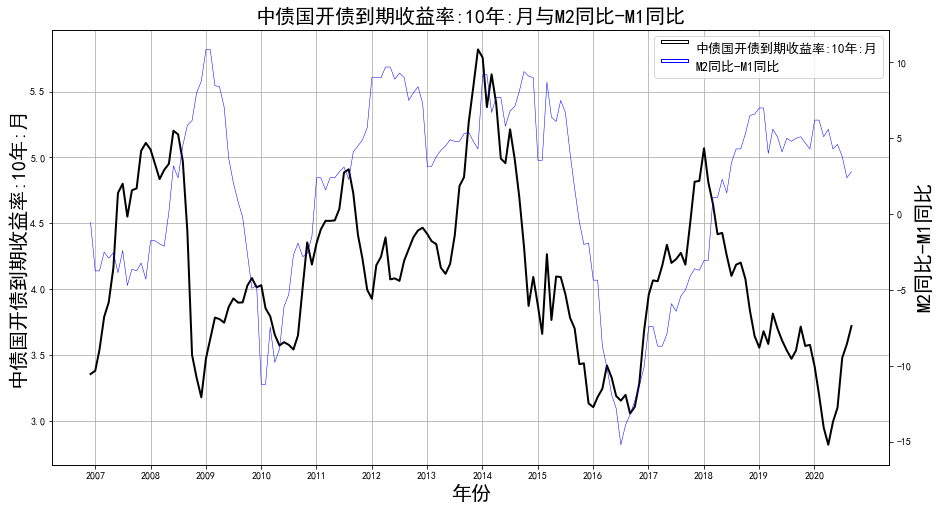

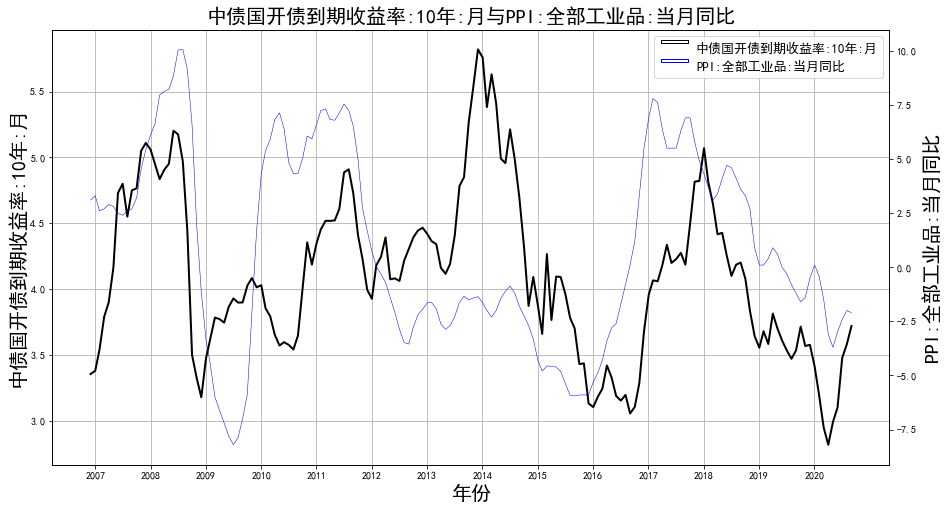

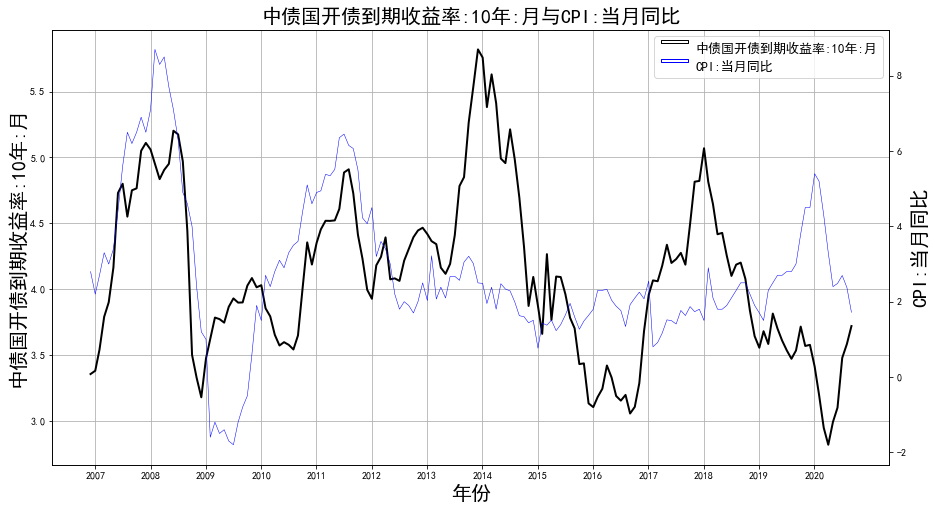

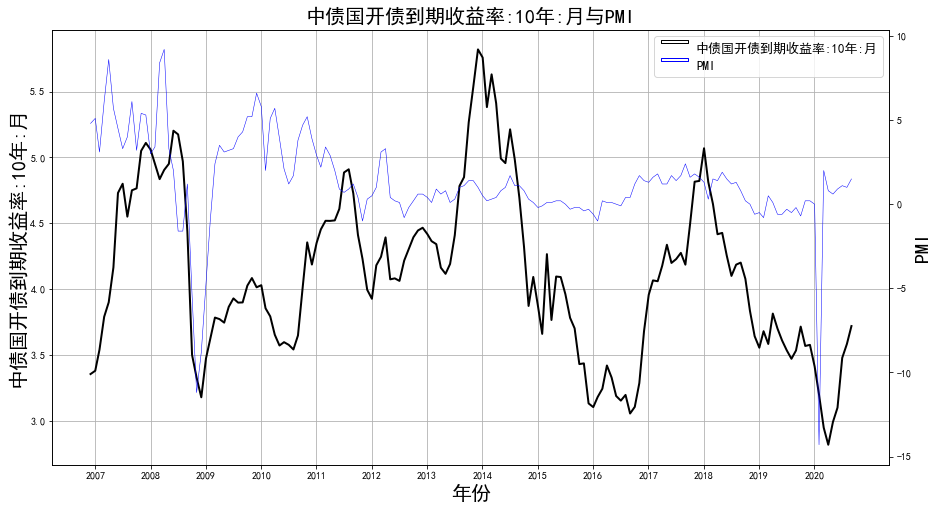

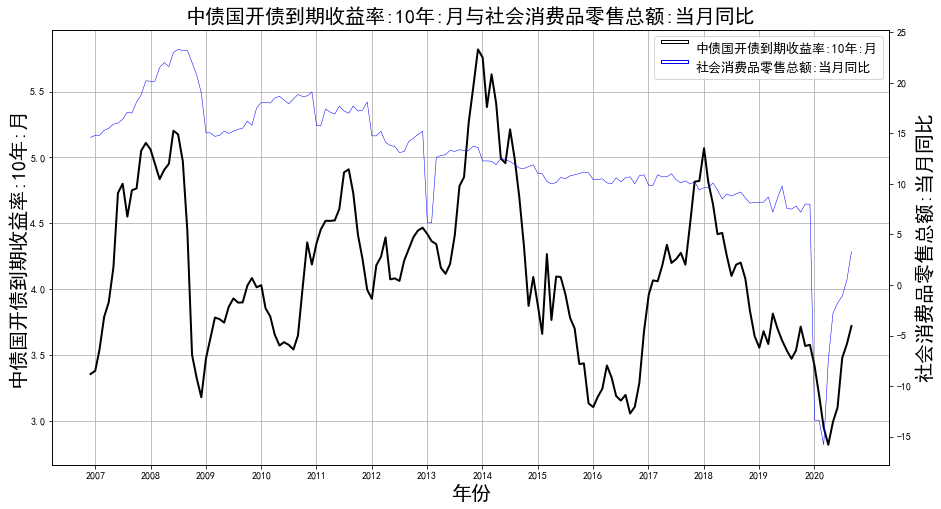

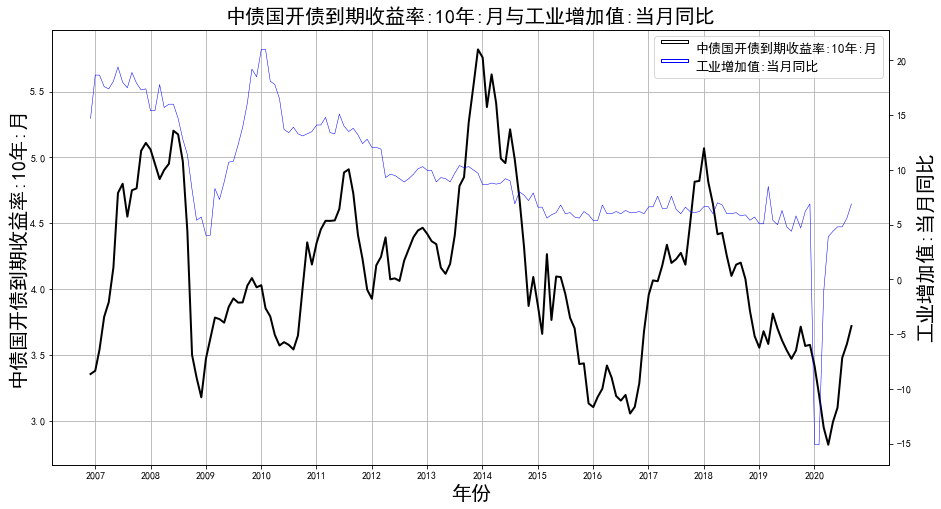

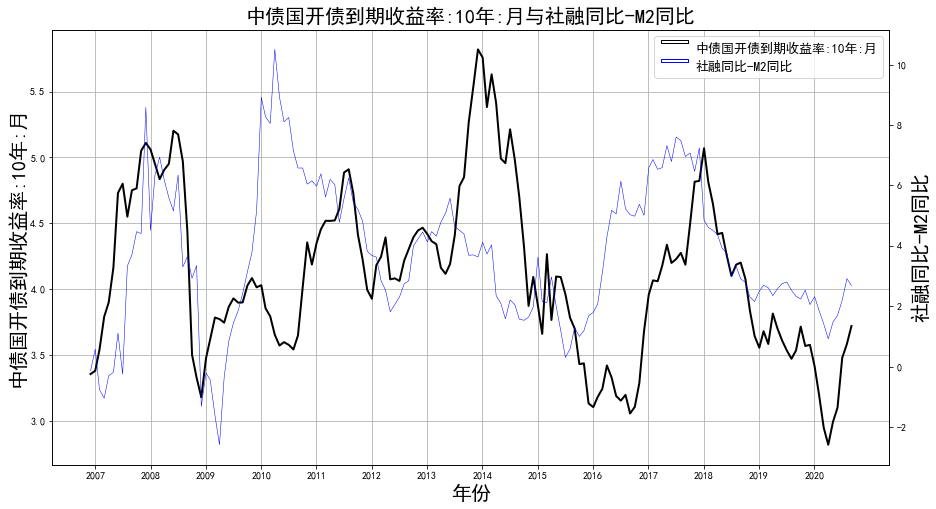

In [188]:
for i in range(1,len(data)):
    plt.rcParams['font.family']=['SimHei']
    plt.rcParams['axes.unicode_minus']=False
    fig, ax = plt.subplots(figsize=(15,8))
    
    ax.set_title(c_name[0]+'与'+c_name[i],fontproperties='SimHei', size = 20)
    ax.plot(d8, data[0], color='black', linewidth = 2, label = c_name[0])
    ax.plot(d8, data[0], color='b', linewidth = 0, label = c_name[i])
    
    plt.grid()
    plt.xlabel(u'年份',fontproperties='SimHei',fontsize = 20)
    plt.xticks([i for i in range(d8[find1y(date)],d8[-1],365)], [date[i].year for i in range(find1y(date),len(d8),12)])
    plt.ylabel(c_name[0],fontproperties='SimHei',fontsize = 20)

    ax2 = ax.twinx()
    ax2.plot(d8, data[i], color='b', linewidth = .5)
    plt.ylabel(c_name[i],fontproperties='SimHei',fontsize = 20)

    colors = ['black', 'blue']
    new_legends = ['-'] * len(colors)
    markers = ['-'] * len(colors)

    _, labels = ax.get_legend_handles_labels()

    duplicates = [dupe_legend(leg, color) for leg, color in zip(new_legends, colors)]
    ax.legend(duplicates, labels, numpoints=1, markerscale=5, fontsize=13)

    plt.show()

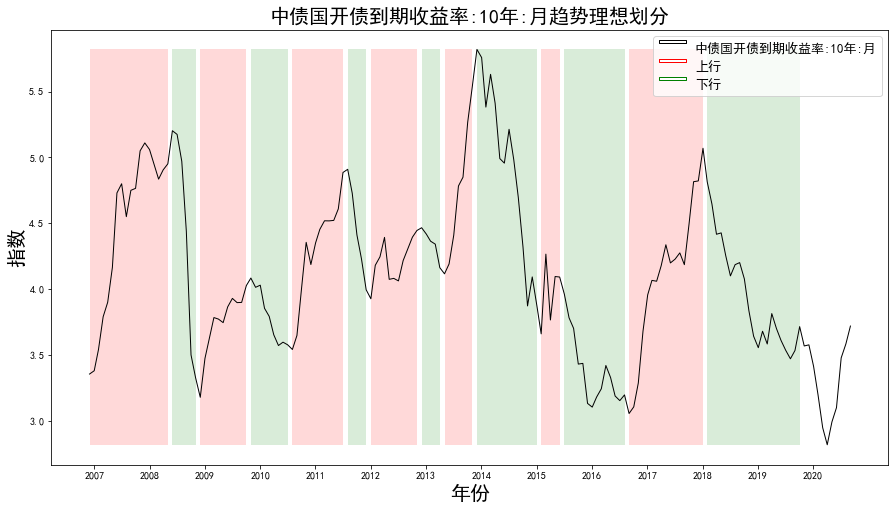

中债国开债到期收益率:10年:月趋势理想划分复杂度 9.04 %


In [30]:
ii = 0
plt.rcParams['font.family']=['SimHei']
fig, ax = plt.subplots(figsize=(15,8))
ax.set_title(list(d)[ii]+'趋势理想划分',fontproperties='SimHei', size = 20)
ax.plot(d8, data[ii], color='black', linewidth = 1, label = list(d)[ii])

plt.xlabel(u'年份',fontproperties='SimHei',fontsize = 20)
plt.xticks([i for i in range(d8[find1y(date)],d8[-1],365)], [date[i].year for i in range(find1y(date),len(d8),12)])
plt.ylabel(u'指数',fontproperties='SimHei',fontsize = 20)

collection = collections.BrokenBarHCollection.span_where(
d8, ymin=min(data[ii]), ymax=max(data[ii]), where=np.array(eval('ud'+str(ii))) == 1, facecolor='red', alpha=.15, label = '上行')
ax.add_collection(collection)

collection = collections.BrokenBarHCollection.span_where(
d8, ymin=min(data[ii]), ymax=max(data[ii]), where=np.array(eval('ud'+str(ii))) == -1, facecolor='green', alpha=.15, label = '下行')
ax.add_collection(collection)

colors = ['black', 'red', 'green']
new_legends = ["-"] * len(colors)
markers = ['-'] * len(colors)

_, labels = ax.get_legend_handles_labels()

duplicates = [dupe_legend(leg, color) for leg, color in zip(new_legends, colors)]
ax.legend(duplicates, labels, numpoints=1, markerscale=5, fontsize=13)

exec('bc' + str(ii) + '= round( cpx(ud'+str(ii)+')  *100  ,  2    )  ')

plt.show()
print(list(d)[ii]+'趋势理想划分复杂度', eval('bc' + str(ii)),'%')

# 回归分析选择变量

## 线性回归

In [77]:
tr = pd.DataFrame(x, columns = c_name[1:])
lr_1=sm.OLS(y,tr)
lr_1 = lr_1.fit()
lr_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.941
Model:                            OLS   Adj. R-squared (uncentered):              0.938
Method:                 Least Squares   F-statistic:                              359.3
Date:                Thu, 19 Nov 2020   Prob (F-statistic):                    5.52e-94
Time:                        09:02:54   Log-Likelihood:                         -237.97
No. Observations:                 166   AIC:                                      489.9
Df Residuals:                     159   BIC:                                      511.7
Df Model:                           7                                                  
Covariance Type:            nonrobust                                                  
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
M2同比-M1同比          0.0991      0.017      5.945      0.000       0.066       0.132
PPI:全部工业品:当月同比    -0.1800      0.024     -7.526      0.000      -0.227      -0.133
CPI:当月同比           0.2869      0.052      5.531      0.000       0.184       0.389
PMI                0.0164      0.045      0.366      0.715      -0.072       0.105
社会消费品零售总额:当月同比     0.0849      0.024      3.527      0.001       0.037       0.132
工业增加值:当月同比         0.0482      0.036      1.336      0.183      -0.023       0.119
社融同比-M2同比          0.4171      0.040     10.427      0.000       0.338       0.496
==============================================================================
Omnibus:                       11.056   Durbin-Watson:                   0.247
Prob(Omnibus):                  0.004   Jarque-Bera (JB):                4.483
Skew:                           0.049   Prob(JB):                        0.106
Kurtosis:                       2.201   Cond. No.                         14.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

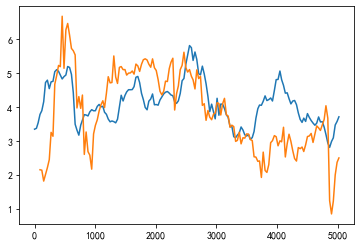

In [78]:
prd = 3
plt.plot(d8,data[0])
plt.plot(d8[prd:],lr_1.predict(x[:-prd]))

Text(0, 0.5, '最优滞后月份')

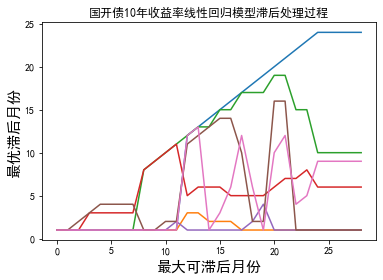

In [200]:
plt.plot(lag_res)
plt.title('国开债10年收益率线性回归模型滞后处理过程')
plt.xlabel(u'最大可滞后月份',fontproperties='SimHei',fontsize = 15)
plt.ylabel(u'最优滞后月份',fontproperties='SimHei',fontsize = 15)

1
[1, 1, 1, 1, 1, 1, 1]


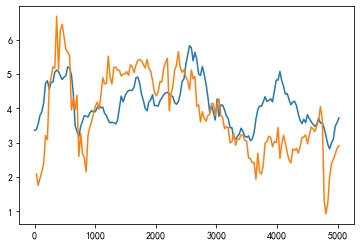

2
[1, 1, 1, 1, 1, 1, 1]


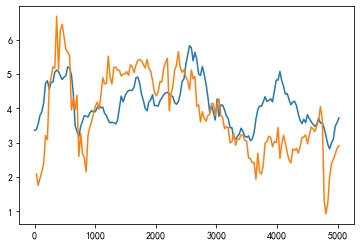

3
[1, 1, 1, 1, 1, 2, 1]


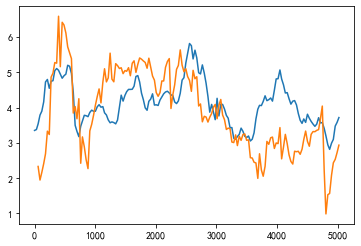

4
[1, 1, 1, 3, 1, 3, 1]


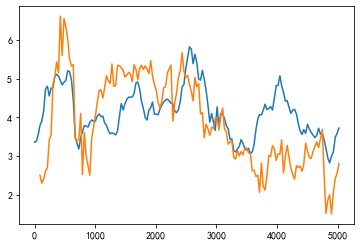

5
[1, 1, 1, 3, 1, 4, 1]


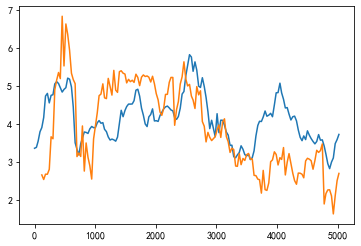

6
[1, 1, 1, 3, 1, 4, 1]


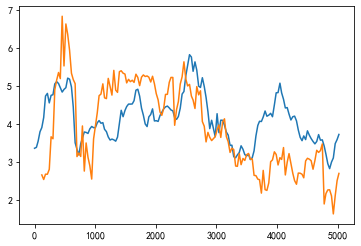

7
[1, 1, 1, 3, 1, 4, 1]


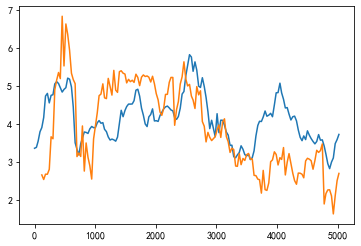

8
[1, 1, 1, 3, 1, 4, 1]


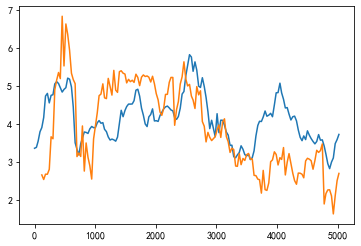

9
[1, 1, 8, 8, 1, 1, 1]


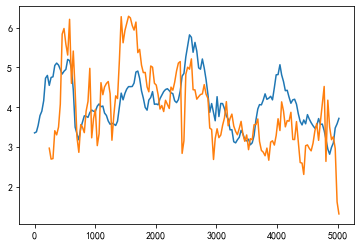

10
[1, 1, 9, 9, 1, 1, 1]


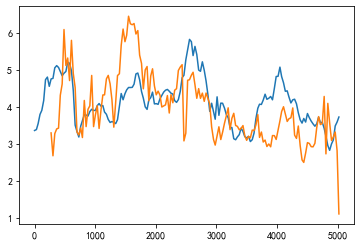

11
[1, 1, 10, 10, 1, 2, 1]


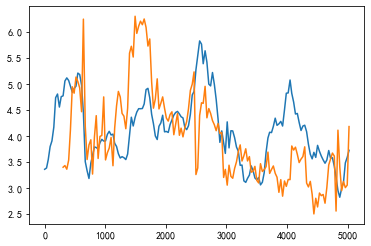

12
[1, 1, 11, 11, 2, 2, 1]


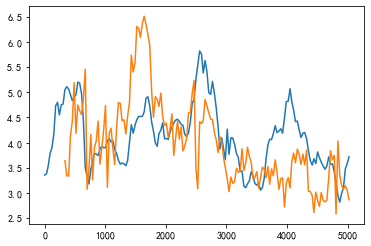

13
[12, 3, 12, 5, 1, 11, 12]


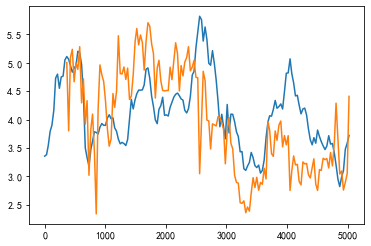

14
[13, 3, 13, 6, 1, 12, 13]


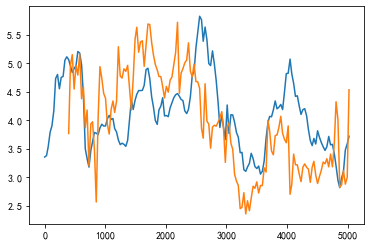

15
[14, 2, 13, 6, 1, 13, 1]


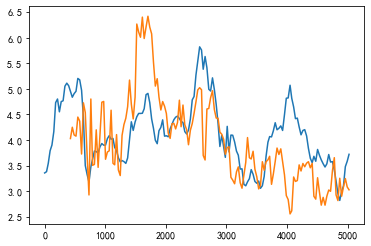

16
[15, 2, 15, 6, 1, 14, 3]


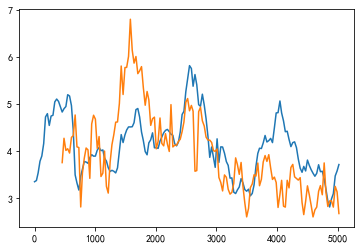

17
[16, 2, 15, 5, 1, 14, 6]


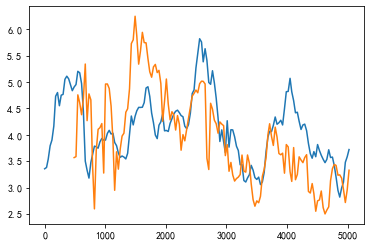

18
[17, 1, 17, 5, 1, 10, 12]


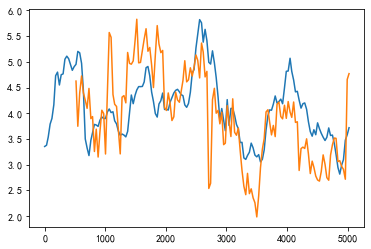

19
[18, 1, 17, 5, 2, 2, 6]


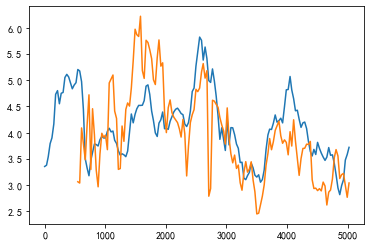

20
[19, 1, 17, 5, 4, 2, 1]


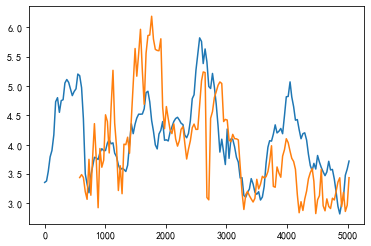

21
[20, 1, 19, 6, 1, 16, 10]


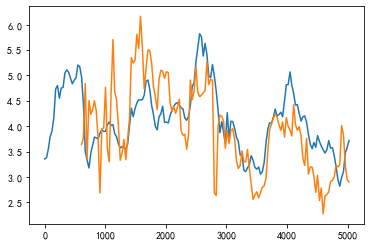

22
[21, 1, 19, 7, 1, 16, 12]


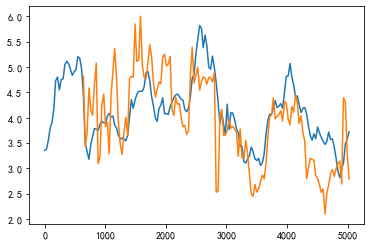

23
[22, 1, 15, 7, 1, 1, 4]


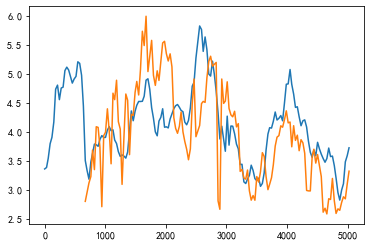

24
[23, 1, 15, 8, 1, 1, 5]


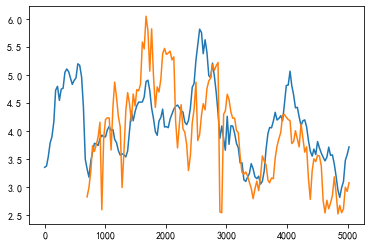

25
[24, 1, 10, 6, 1, 1, 9]


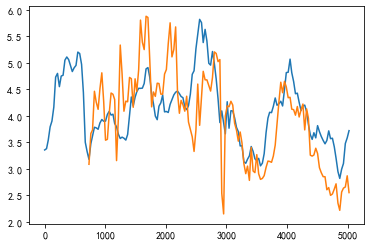

26
[24, 1, 10, 6, 1, 1, 9]


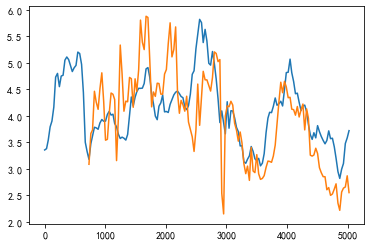

27
[24, 1, 10, 6, 1, 1, 9]


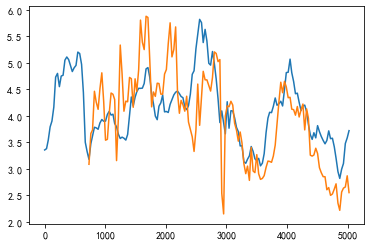

28
[24, 1, 10, 6, 1, 1, 9]


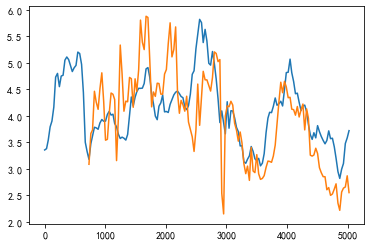

29
[24, 1, 10, 6, 1, 1, 9]


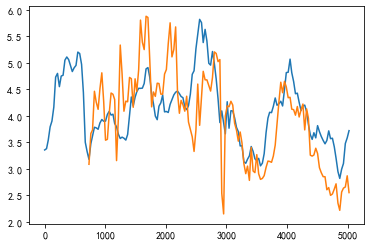

In [195]:
lag_res = []
for lim in range(1,30):
    print(lim)
    lagging = [1 for i in range(len(data[1:]))]
    best_rs = 0 

    for i in range(len(lagging)):
        best_lag = 1
        for j in range(1,lim):
            lagging[i] = j
            lag_x = listran(lagrid(data[1:],lagging))
            lag_y = y[-len(lag_x):]

            lr_l=sm.OLS(lag_y,lag_x)
            lr_l = lr_l.fit()
            if lr_l.rsquared > best_rs:
                best_rs = lr_l.rsquared
                best_lag = j
            else:
                continue
        lagging[i] = best_lag
    lag_res.append(lagging)
    print(lagging)
    lag_x = listran(lagrid(data[1:],lagging))
    lag_x = pd.DataFrame(lag_x, columns = [c_name[i+1]+'-'+str(lagging[i]) for i in range(len(c_name[1:]))])
    lag_y = y[-len(lag_x):]

    lr_l=sm.OLS(lag_y,lag_x).fit()

    plt.plot(d8,data[0])
    plt.plot(d8[-len(lag_x):],lr_l.predict(lag_x))
    plt.show()

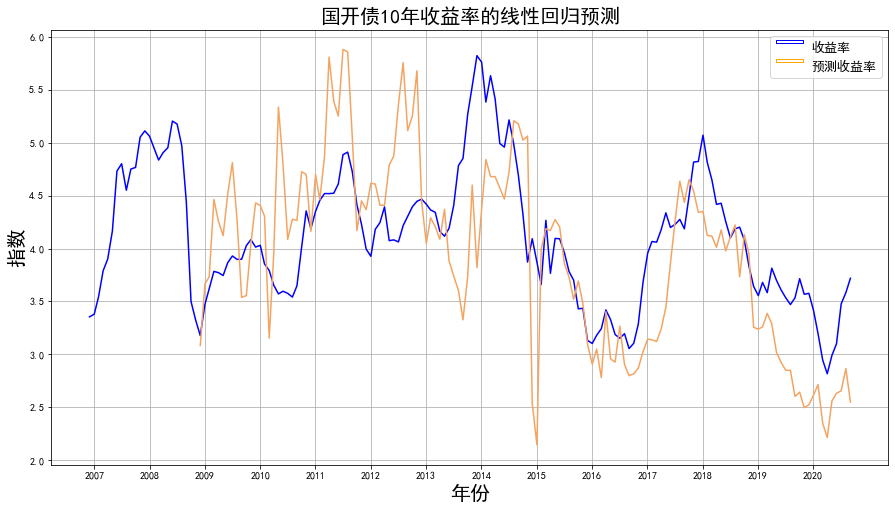

In [186]:
plt.rcParams['font.family']=['SimHei']
fig, ax = plt.subplots(figsize=(15,8))
ax.set_title('国开债10年收益率的线性回归预测',fontproperties='SimHei', size = 20)
ax.plot(d8, data[0], color='blue', linewidth = 1.5, label = '收益率')
ax.plot(d8[-len(lag_x):],lr_l.predict(lag_x), color='sandybrown', linewidth = 1.5, label = '预测收益率')

plt.grid()
plt.xlabel(u'年份',fontproperties='SimHei',fontsize = 20)
plt.xticks([i for i in range(d8[find1y(date)],d8[-1],365)], [date[i].year for i in range(find1y(date),len(d8),12)])
plt.ylabel(u'指数',fontproperties='SimHei',fontsize = 20)

colors = ['blue', 'orange']
new_legends = ["-"] * len(colors)
markers = ['-'] * len(colors)

_, labels = ax.get_legend_handles_labels()

duplicates = [dupe_legend(leg, color) for leg, color in zip(new_legends, colors)]
ax.legend(duplicates, labels, numpoints=1, markerscale=5, fontsize=13)

plt.show()

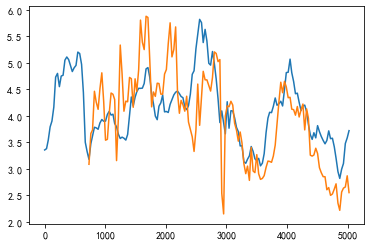

In [180]:
lagging = [24, 1, 10, 6, 1, 1, 9]
lag_x = listran(lagrid(data[1:],lagging))
lag_x = pd.DataFrame(lag_x, columns = [c_name[i+1]+'-'+str(lagging[i]) for i in range(len(c_name[1:]))])
lag_y = y[-len(lag_x):]

lr_l=sm.OLS(lag_y,lag_x).fit()

plt.plot(d8,data[0])
plt.plot(d8[-len(lag_x):],lr_l.predict(lag_x))
plt.show()

In [181]:
lr_l.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.972
Model:                            OLS   Adj. R-squared (uncentered):              0.970
Method:                 Least Squares   F-statistic:                              664.9
Date:                Thu, 19 Nov 2020   Prob (F-statistic):                   2.67e-101
Time:                        10:18:47   Log-Likelihood:                         -148.42
No. Observations:                 142   AIC:                                      310.8
Df Residuals:                     135   BIC:                                      331.5
Df Model:                           7                                                  
Covariance Type:            nonrobust                                                  
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
M2同比-M1同比-24         0.0287      0.012      2.379      0.019       0.005       0.053
PPI:全部工业品:当月同比-1    -0.0985      0.016     -6.341      0.000      -0.129      -0.068
CPI:当月同比-10          0.1473      0.052      2.836      0.005       0.045       0.250
PMI-6               -0.1733      0.032     -5.482      0.000      -0.236      -0.111
社会消费品零售总额:当月同比-1     0.2925      0.018     16.040      0.000       0.256       0.329
工业增加值:当月同比-1        -0.1202      0.028     -4.221      0.000      -0.177      -0.064
社融同比-M2同比-9          0.2417      0.033      7.403      0.000       0.177       0.306
==============================================================================
Omnibus:                        0.269   Durbin-Watson:                   0.506
Prob(Omnibus):                  0.874   Jarque-Bera (JB):                0.078
Skew:                          -0.042   Prob(JB):                        0.962
Kurtosis:                       3.078   Cond. No.                         18.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [168]:
new_lag = lagging[:5]+[lagging[6]]
col_name = lag_x.columns
mew_name =  c_name[:5]+[c_name[7]]
lag_x = listran(lagrid(data[1:6]+[data[7]],lagging))
lag_x = pd.DataFrame(lag_x, columns = [mew_name[i]+'-'+str(new_lag[i]) for i in range(len(mew_name))])
lag_y = y[-len(lag_x):]

lr_l=sm.OLS(lag_y,lag_x).fit()
lr_l.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.960
Model:                            OLS   Adj. R-squared (uncentered):              0.958
Method:                 Least Squares   F-statistic:                              590.2
Date:                Thu, 19 Nov 2020   Prob (F-statistic):                   1.17e-100
Time:                        09:56:57   Log-Likelihood:                         -190.14
No. Observations:                 154   AIC:                                      392.3
Df Residuals:                     148   BIC:                                      410.5
Df Model:                           6                                                  
Covariance Type:            nonrobust                                                  
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
中债国开债到期收益率:10年:月-12     0.1015      0.015      6.560      0.000       0.071       0.132
M2同比-M1同比-3            -0.0639      0.017     -3.684      0.000      -0.098      -0.030
PPI:全部工业品:当月同比-12       0.1441      0.045      3.234      0.002       0.056       0.232
CPI:当月同比-5             -0.1447      0.030     -4.853      0.000      -0.204      -0.086
PMI-1                   0.1633      0.011     14.761      0.000       0.141       0.185
社融同比-M2同比-12            0.3621      0.042      8.587      0.000       0.279       0.445
==============================================================================
Omnibus:                        0.293   Durbin-Watson:                   0.382
Prob(Omnibus):                  0.864   Jarque-Bera (JB):                0.456
Skew:                          -0.007   Prob(JB):                        0.796
Kurtosis:                       2.734   Cond. No.                         12.1
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

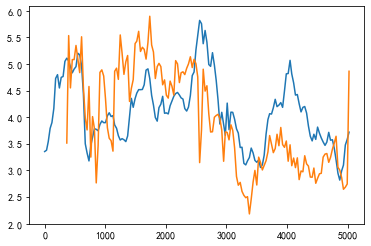

In [170]:
plt.plot(d8,data[0])
plt.plot(d8[-len(lag_x):],lr_l.predict(lag_x))
plt.show()

# 涨跌预测分类

In [37]:
prd_l = 3
step = 3
ii = 0
df = data_pro(data[0:4]+[data[5]]+[data[7]],l)


## 逻辑回归

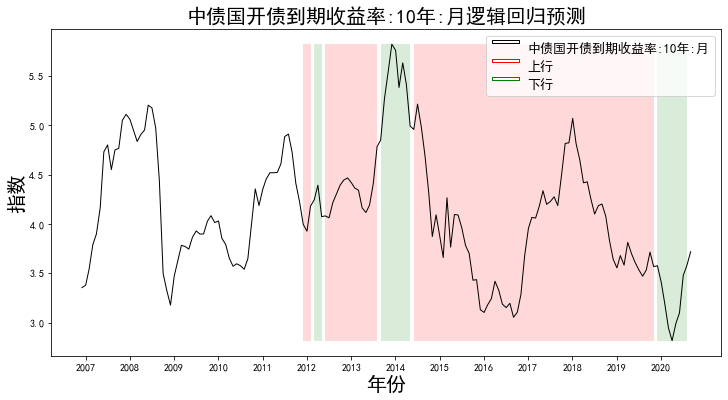

准确率 49.0 %
相对复杂度 0.96
单位时间收益率 -0.32


In [38]:
m_name = '逻辑回归'
logr = LogisticRegression()

data_bond = df
logr_prd = []
for i in range(start,len(date)):
    cur_ud = und(data[ii][:i+1], w_fast, w_slow)[l-1:-w_slow]
    l_ud = len(cur_ud) - prd_l        
    logr.fit(data_bond[:l_ud], cur_ud[prd_l:])
    logr_res = -(-1) ** (logr.predict( [data_bond[i-l]] ) >= 0)[0]
    logr_prd.append(logr_res)

_res = []

logr_prd = logr_prd[::-1]

for i in range(0, len(logr_prd), step):
    if i+step >= (len(logr_prd) - 1):
        _res += [-(-1) ** (sum(logr_prd[i:i+step]) >= 0)]*(len(logr_prd)-1-i)
        break
    else:
        _res += [-(-1) ** (sum(logr_prd[i:i+step]) >= 0)]*step

_res = _res[::-1]

supa_plot(d, _res, ii, m_name)

c += 1

temp_l = len(_res[:-w_slow])

exec('a' + str(c) + '= 100*acc(_res[:-w_slow],ud'+str(ii)+'[:-w_slow][-temp_l:])')
exec('c' + str(c) + '= round(100*cpx(_res)/bc'+str(ii)+',2)')
exec('p' + str(c) + '= round(profit(data['+str(ii)+'][-len(_res):], _res)*100,2)')

print('准确率', eval('a'+str(c)),'%')
print('相对复杂度', eval('c'+str(c)))
print('单位时间收益率', eval('p'+str(c)))

r_name.append(m_name)

## 决策树

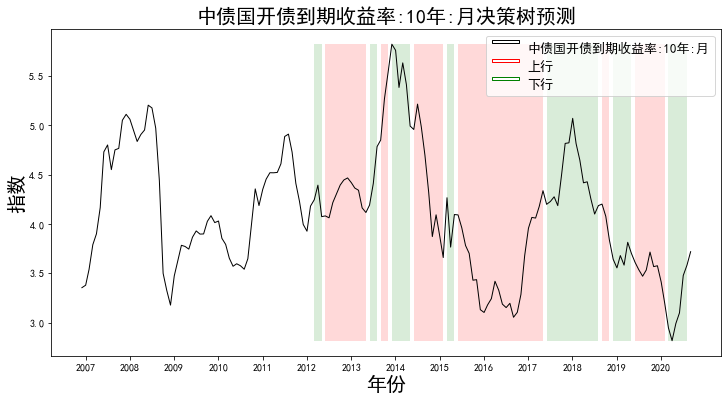

准确率 35.0 %
相对复杂度 1.48
单位时间收益率 -0.48


In [39]:
m_name = '决策树'
tr = DecisionTreeClassifier()

data_bond = df
tr_prd = []
prt = 0
for i in range(start+prd_l,len(date)):
    cur_ud = und(data[ii][:i+1], w_fast, w_slow)[l-1:-w_slow]
    l_ud = len(cur_ud) - prd_l        
    tr.fit(  data_bond[:l_ud] ,  cur_ud[prd_l:])
    tr_res = -(-1) ** (tr.predict( [data_bond[i-l]] ) >= 0)[0]
    tr_prd.append(tr_res)
    if i == len(date) - 1 and prt == 1:
        tree.plot_tree(tr)
        dot_data = tree.export_graphviz(tr, out_file="tre.dot") 
    
_res = []
tr_prd = tr_prd[::-1]

for i in range(0, len(tr_prd), step):
    if i+step >= (len(tr_prd) - 1):
        _res += [-(-1) ** (sum(tr_prd[i:i+step]) >= 0)]*(len(tr_prd)-1-i)
        break
    else:
        _res += [-(-1) ** (sum(tr_prd[i:i+step]) >= 0)]*step

_res = _res[::-1]

supa_plot(d, _res, ii, m_name)

c += 1

temp_l = len(_res[:-w_slow])


exec('a' + str(c) + '= 100*acc(_res[:-w_slow],ud'+str(ii)+'[:-w_slow][-temp_l:])')
exec('c' + str(c) + '= round(100*cpx(_res)/bc'+str(ii)+',2)')
exec('p' + str(c) + '= round(profit(data['+str(ii)+'][-len(_res):], _res)*100,2)')

print('准确率', eval('a'+str(c)),'%')
print('相对复杂度', eval('c'+str(c)))
print('单位时间收益率', eval('p'+str(c)))
    
r_name.append(m_name)

In [40]:
#dot -Tpng tre.dot -o tre.png

## 随机森林

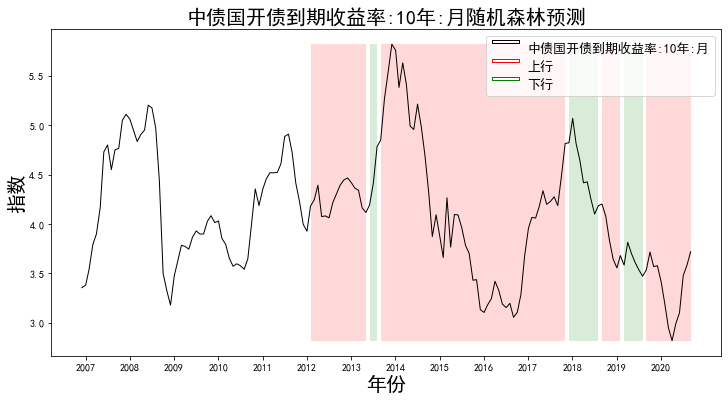

准确率 38.0 %
相对复杂度 0.89
单位时间收益率 -0.43


In [41]:
m_name = '随机森林'
rf = RandomForestRegressor(n_estimators = 10)

data_bond =df
rf_prd = []
for i in range(start+prd_l,len(date)):

        cur_ud = und(data[ii][:i+1], w_fast, w_slow)[l-1:-w_slow]
        l_ud = len(cur_ud) -prd_l
        rf.fit(  data_bond[:l_ud] ,  cur_ud[prd_l:])
        rf_res = -(-1) ** (rf.predict( [data_bond[i-l]] ) >= 0)[0]
        rf_prd += [rf_res]

_res = []
rf_prd = rf_prd[::-1]

for i in range(0, len(rf_prd), step):
    if i+step >= (len(rf_prd) - 1):
        _res += [-(-1) ** (sum(rf_prd[i:i+step]) >= 0)]*(len(rf_prd)-1-i)
        break
    else:
        _res += [-(-1) ** (sum(rf_prd[i:i+step]) >= 0)]*step

_res = _res[::-1]

supa_plot(d, _res, ii, m_name)

c += 1

temp_l = len(_res[:-w_slow])

exec('a' + str(c) + '= 100*acc(_res[:-w_slow],ud'+str(ii)+'[:-w_slow][-temp_l:])')
exec('c' + str(c) + '= round(100*cpx(_res)/bc'+str(ii)+',2)')
exec('p' + str(c) + '= round(profit(data['+str(ii)+'][-len(_res):], _res)*100,2)')

print('准确率', eval('a'+str(c)),'%')
print('相对复杂度', eval('c'+str(c)))
print('单位时间收益率', eval('p'+str(c)))
    
r_name.append(m_name)

## XGBoost

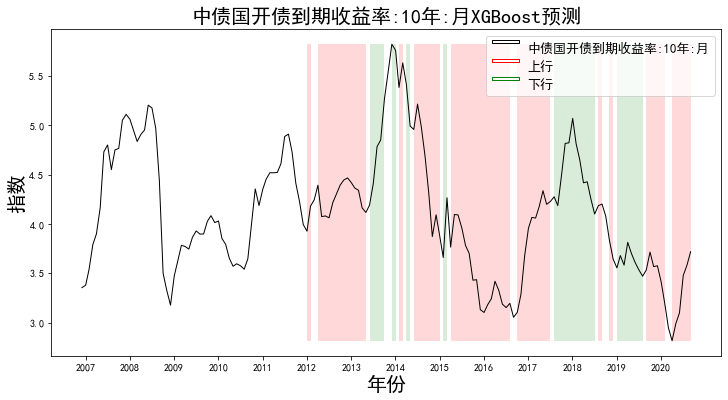

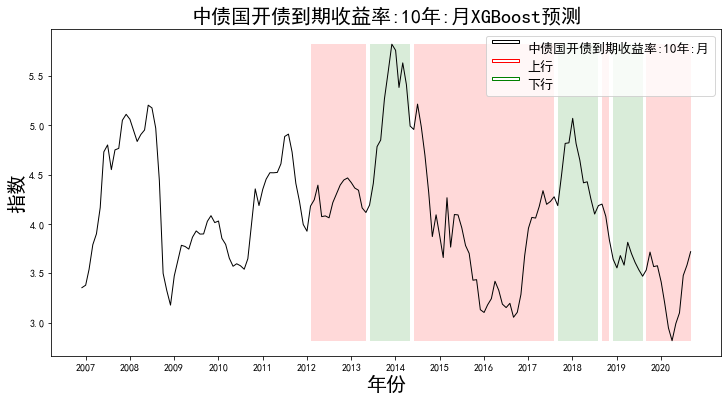

准确率 37.0 %
相对复杂度 0.79
单位时间收益率 -0.63


In [42]:
param = {'learning_rate':0.1,'objective':'binary:logistic' }
num_round = 100
m_name = 'XGBoost'

xg_prd = []
data_bond = df

for i in range(start+prd_l,len(date)):
    cur_ud = und(data[ii][:i+1], w_fast, w_slow)[l-1:-w_slow]
    l_ud = len(cur_ud) - prd_l
    dtrain = xgb.DMatrix(np.array(data_bond[:l_ud]), label = np.array(cur_ud[prd_l:])==1)
    dtest = xgb.DMatrix(np.array([data_bond[i-l]]))
    bst = xgb.train(param, dtrain, num_round)
    xg_prd.append(-(-1) ** ((bst.predict(dtest))>=.5)[0])

_res = []

supa_plot(d, xg_prd, ii, m_name)

xg_prd = xg_prd[::-1]

for i in range(0, len(xg_prd), step):
    if i+step >= (len(xg_prd) - 1):
        _res += [-(-1) ** (sum(xg_prd[i:i+step]) >= 0)]*(len(xg_prd)-1-i)
        break
    else:
        _res += [-(-1) ** (sum(xg_prd[i:i+step]) >= 0)]*step

_res = _res[::-1]

supa_plot(d, _res, ii, m_name)

temp_l = len(_res[:-w_slow])

c += 1

exec('a' + str(c) + '= 100*acc(_res[:-w_slow],ud'+str(ii)+'[:-w_slow][-temp_l:])')
exec('c' + str(c) + '= round(100*cpx(_res)/bc'+str(ii)+',2)')
exec('p' + str(c) + '= round(profit(data['+str(ii)+'][-len(_res):], _res)*100,2)')

print('准确率', eval('a'+str(c)),'%')
print('相对复杂度', eval('c'+str(c)))
print('单位时间收益率', eval('p'+str(c)))
    
r_name.append(m_name)

## SVM

### 线性

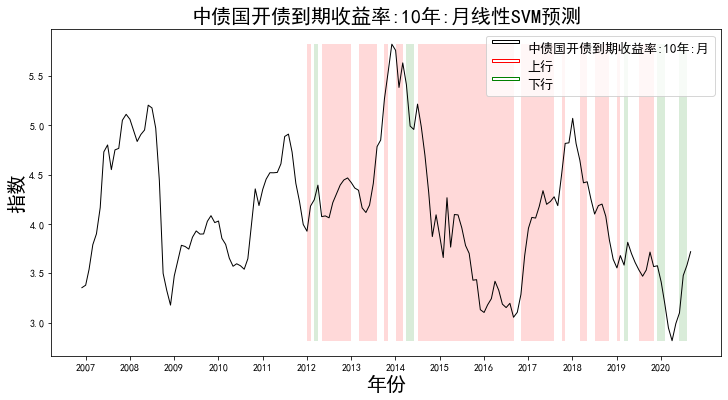

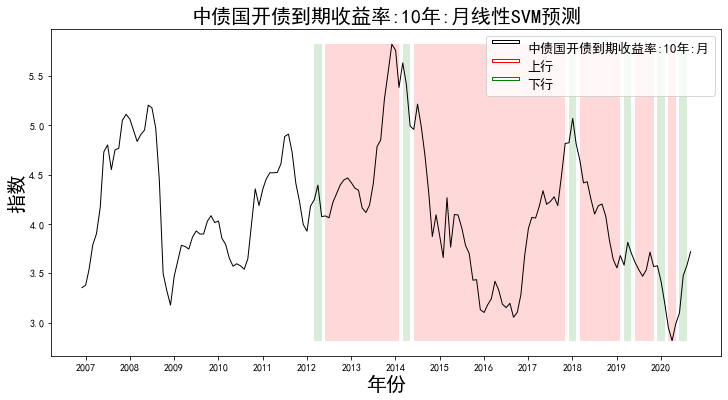

准确率 43.0 %
相对复杂度 1.28
单位时间收益率 -0.12


In [43]:
_svm1 = svm.SVC(kernel='linear')
m_name = '线性SVM'

svm_prd = []
data_bond = df
for i in range(start+prd_l,len(date)):
    cur_ud = und(data[ii][:i+1], w_fast, w_slow)[l-1:-w_slow]
    l_ud = len(cur_ud) - prd_l
    _svm1.fit(  data_bond[:l_ud],  cur_ud[prd_l:] )
    svm_res =   -(-1) ** (_svm1.predict( [data_bond[i-l]] ) >= 0)[0]
    svm_prd.append(svm_res)

_res = []

supa_plot(d, svm_prd, ii, m_name)
svm_prd = svm_prd[::-1]

for i in range(0, len(svm_prd), step):
    if i+step >= (len(svm_prd) - 1):
        _res += [-(-1) ** (sum(svm_prd[i:i+step]) >= 0)]*(len(svm_prd)-1-i)
        break
    else:
        _res += [-(-1) ** (sum(svm_prd[i:i+step]) >= 0)]*step

_res = _res[::-1]

supa_plot(d, _res, ii, m_name)

temp_l = len(_res[:-w_slow])

c += 1

exec('a' + str(c) + '= 100*acc(_res[:-w_slow],ud'+str(ii)+'[:-w_slow][-temp_l:])')
exec('c' + str(c) + '= round(100*cpx(_res)/bc'+str(ii)+',2)')
exec('p' + str(c) + '= round(profit(data['+str(ii)+'][-len(_res):], _res)*100,2)')

print('准确率', eval('a'+str(c)),'%')
print('相对复杂度', eval('c'+str(c)))
print('单位时间收益率', eval('p'+str(c)))
    
r_name.append(m_name)

### 高斯

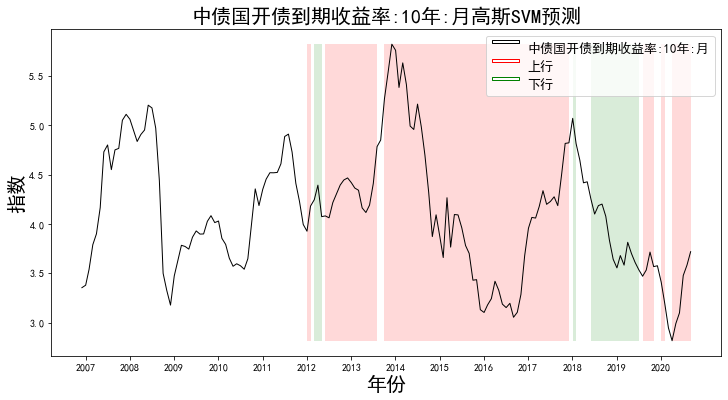

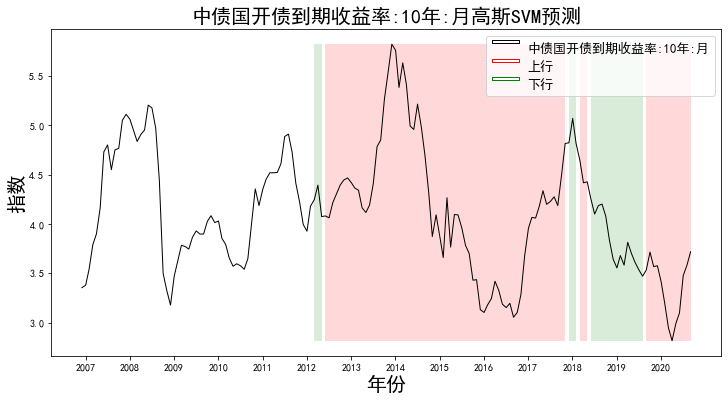

准确率 47.0 %
相对复杂度 0.69
单位时间收益率 0.1


In [44]:
_svm3 = svm.SVC(kernel='rbf')
m_name = '高斯SVM'

svm_prd = []
data_bond = df
for i in range(start+prd_l,len(date)):
    cur_ud = und(data[ii][:i+1], w_fast, w_slow)[l-1:-w_slow]
    l_ud = len(cur_ud) - prd_l
    _svm3.fit(  data_bond[:l_ud],  cur_ud[prd_l:] )
    svm_res =   -(-1) ** (_svm3.predict( [data_bond[i-l]] ) >= 0)[0]
    svm_prd.append(svm_res)

_res = []

supa_plot(d, svm_prd, ii, m_name)
svm_prd = svm_prd[::-1]

for i in range(0, len(svm_prd), step):
    if i+step >= (len(svm_prd) - 1):
        _res += [-(-1) ** (sum(svm_prd[i:i+step]) >= 0)]*(len(svm_prd)-1-i)
        break
    else:
        _res += [-(-1) ** (sum(svm_prd[i:i+step]) >= 0)]*step

_res = _res[::-1]

supa_plot(d, _res, ii, m_name)

temp_l = len(_res[:-w_slow])

c += 1

exec('a' + str(c) + '= 100*acc(_res[:-w_slow],ud'+str(ii)+'[:-w_slow][-temp_l:])')
exec('c' + str(c) + '= round(100*cpx(_res)/bc'+str(ii)+',2)')
exec('p' + str(c) + '= round(profit(data['+str(ii)+'][-len(_res):], _res)*100,2)')

print('准确率', eval('a'+str(c)),'%')
print('相对复杂度', eval('c'+str(c)))
print('单位时间收益率', eval('p'+str(c)))
    
r_name.append(m_name)

# 总结

In [45]:
final_result = []
rc = 0
for i in range(1,c+1):
    final_result.append([eval('a'+str(i)), eval('c'+str(i)), eval('p'+str(i))])

with pd.ExcelWriter('imdying.xlsx') as writer:
    name = list(d)[0]
    D = pd.DataFrame(final_result)
    D.columns = ['准确度（%）', '相对复杂度', '单位时间收益率（%）']
    D.index = r_name
    D.to_excel(writer)

writer.save()
writer.close()